# <center> Feature Engineering and ML

In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

## data

In [3]:
data_path = "data"

In [4]:
X_train = np.load(os.path.join(data_path, "X_train.npy"))
X_test = np.load(os.path.join(data_path, "X_test.npy"))
y_train = np.load(os.path.join(data_path, "y_train.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))

In [5]:
X_train.shape, y_train.shape

((7352, 128, 9), (7352, 6))

In [6]:
X_test.shape, y_test.shape

((2947, 128, 9), (2947, 6))

In [8]:
y_train_num = y_train.argmax(1)
y_train_num

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

#### посмотрим на баланс классов

In [9]:
pd.Series(y_train_num).value_counts().sort_index()

0    1226
1    1073
2     986
3    1286
4    1374
5    1407
dtype: int64

В первом приближении классы можно считать близкими к сбалансированным

#### отделим валидационную выборку, она нам может понадобиться для подбора гиперпараметров

In [10]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train_num, test_size=0.25, 
                                                        stratify=y_train_num, random_state=17)
X_train_.shape, X_valid.shape, y_train_.shape, y_valid.shape

((5514, 128, 9), (1838, 128, 9), (5514,), (1838,))

### <center>Feature Engineering

Создадим функцию, которая в порядке Feature Engineering создает фичи из исходных данных.   
Идеи для фичей сформированы в результате визуального анализа данных в предыдущем ноутбуке (см. 01_EDA.ipynb, Часть 2)   
В качестве фичей взяты некоторые статистики временных рядов.   
Также сформированы дополнительные данные с: 
- первыми производными временных рядов и 
- первыми (без нулевого) коэффициентами преобразования фурье (вариант быстрого дискретного преобразования фурье). Эти коэффициенты характеризуют осциляцию рядов 

В качестве фичей взяты некоторые статистики этих дополнительных данных.   

Также некоторые комментарии по фичам - в тексте функции

In [12]:
def create_features(data):
    '''
    The creating of features
    Return: pandas DataFrame
    '''
    seq_num = data.shape[2]
    diff = data[:, 1:, :] - data[:, :-1, :]  # первые производные рядов
    fft = np.fft.fft(data, axis=1)[:, 1:20, :].real  # коэффициенты разложения временных рядов в ряд фурье. 
    # Вариант БДПФ, взята только real часть первых 20 коэффициентов (без нулевого, это константа сдвига, она у нас уже есть)
    # fft - характеризует осциляцию временного ряда
    
    features = np.concatenate(
        (
            np.mean(data, 1),                                        # среднее с учетом выбросов
            np.median(data, 1),                                      # среднее без чувствительности к выбросам
            np.mean(data, 1) - np.median(data, 1),                   # характеризует несимметричность распределения
            np.var(data, 1),                                         # разброс во временном ряде
            np.quantile(data, q=0.25, axis=1),                       # характеризует область верхних значений
            np.quantile(data, q=0.75, axis=1),                       # характеризует область нижних значений 
            np.quantile(data, q=0.75, axis=1) - np.quantile(data, q=0.25, axis=1), # величина разброса значений
            data[:, 64:].mean(1) - data[:, :64].mean(1),             # разница средних первой и второй половины, должна характеризовать тренд
            data.std(1) / data.mean(1),                              # коэффициент вариации
            diff.var(1),                                             # дисперсия первой производной, косвенно характеризует осцилляцию
            fft.mean(1),                                             # среднее первых 20 (без нулевого) коэффициентов фурье, характеризует осцилляцию
            fft.var(1),                                              # дисперсия первых 20 (без нулевого) коэффициентов фурье, характеризует осцилляцию
        ), 
    axis=1
    )
    features = pd.DataFrame(features)
    feature_names = [
        "mean", 
        "median", 
        "mean-med", 
        "var", 
        "q25", 
        "q75", 
        "q75-q25", 
        "mean_r-mean_l", 
        r"std/mean", 
        "dvar", 
        "fmean", 
        "fvar"
    ]
    columns = [col + f"_{num}" for col in feature_names for num in range(seq_num)]
    features.columns = columns
    return features

In [13]:
%%time
train = create_features(X_train_)

Wall time: 1.27 s


In [14]:
train.shape

(5514, 108)

## Сделаеем несколько визуализаций получившихся фичей

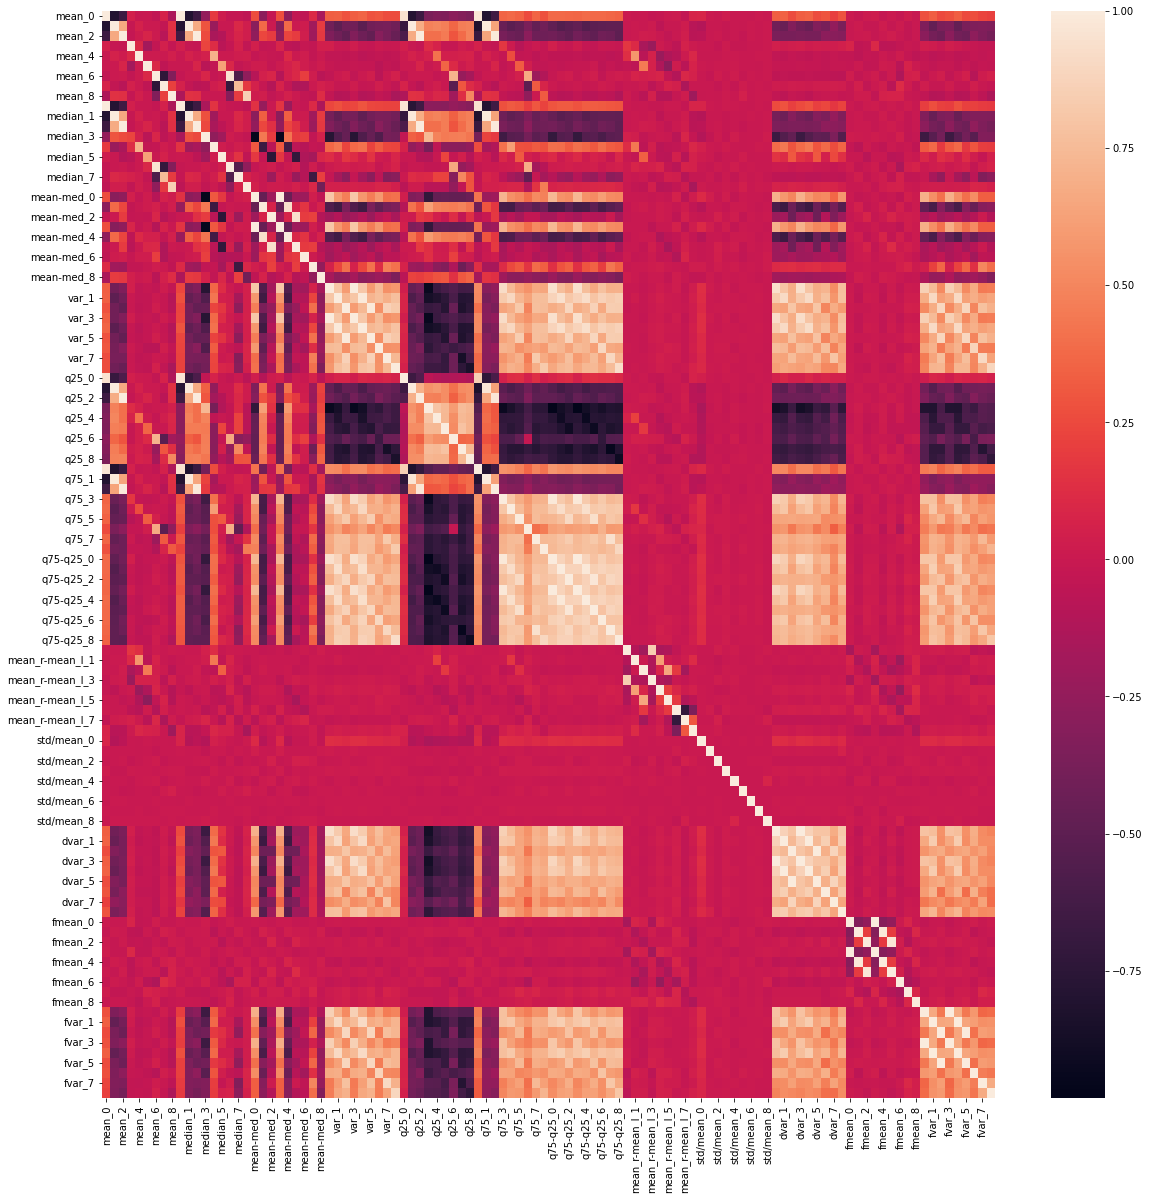

In [15]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(train.corr());

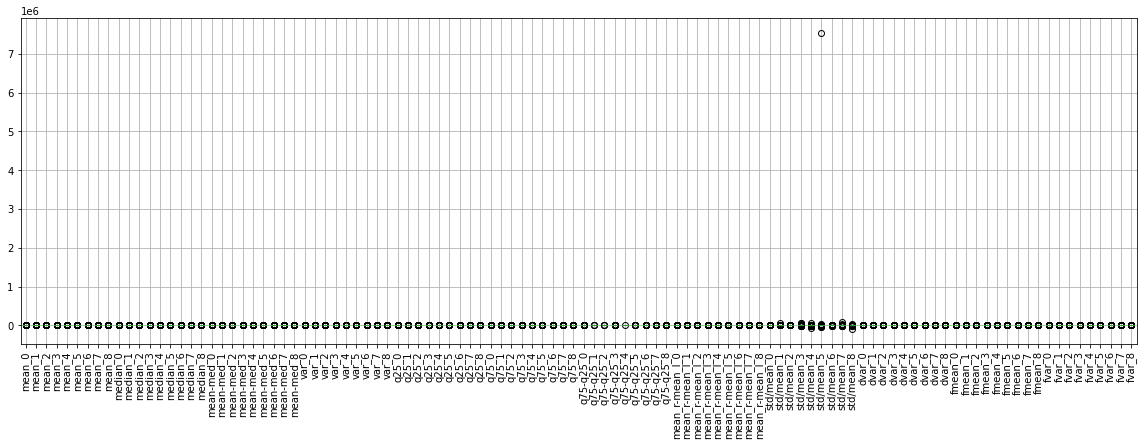

In [16]:
train.boxplot(figsize=(20, 6), rot=90);

получился один явный выброс, попробуем его удалить

In [17]:
dropped = train.columns[((train > 1e6).sum()).astype(bool)]
dropped

Index(['std/mean_5'], dtype='object')

In [18]:
train = train.drop(dropped, axis=1)
train.shape

(5514, 107)

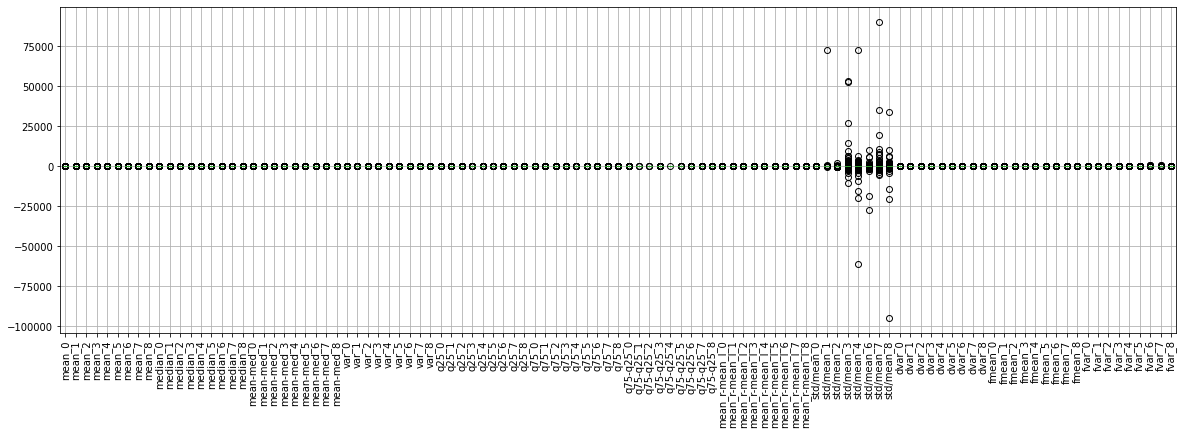

In [19]:
train.boxplot(figsize=(20, 6), rot=90);

Все равно есть выбросы поменьше. Понятно, что это следствие деления на среднее, которое для некоторых рядов близко к нулю.    
Будем использовать градиентный бустинг. Деревья не чувствительны к разбросу, поэтому вернемся к первоначальному варианту и оставим как есть

#### Сформируем фичи и дополнительный формат таргетных меток

In [20]:
%%time
train = create_features(X_train_)

Wall time: 1.25 s


In [21]:
%%time
valid = create_features(X_valid)
test = create_features(X_test)

Wall time: 997 ms


In [22]:
y_test_num = y_test.argmax(1)
y_test_num

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

## <center>ML Classification

#### Будем использовать градиентный бустинг на деревьях в качестве базовой функции, пакет XGBoost.    
В данных достаточно много естественных выбросов, распределения далеки от нормальных. Линейные классификаторы в таких условиях работают не вполне корректно, а деревья к выбросам и разным масштабам фич нечувствительны. Кроме того, деревья вполне неплохо улавливают нелинейности

In [24]:
import xgboost as xgb

In [25]:
dtrain = xgb.DMatrix(train, label=y_train_)
dvalid = xgb.DMatrix(valid, label=y_valid)
dtest = xgb.DMatrix(test, label=y_test_num)

In [26]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softprob'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class'] = 6

In [27]:
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

In [28]:
bst = xgb.train(param, dtrain=dtrain, evals=evallist, num_boost_round=1000, early_stopping_rounds=10)

[0]	train-auc:0.97454	eval-auc:0.96906
[1]	train-auc:0.99180	eval-auc:0.98778
[2]	train-auc:0.99507	eval-auc:0.99173
[3]	train-auc:0.99691	eval-auc:0.99414
[4]	train-auc:0.99794	eval-auc:0.99518
[5]	train-auc:0.99875	eval-auc:0.99635
[6]	train-auc:0.99921	eval-auc:0.99698
[7]	train-auc:0.99947	eval-auc:0.99749
[8]	train-auc:0.99961	eval-auc:0.99764
[9]	train-auc:0.99974	eval-auc:0.99803
[10]	train-auc:0.99982	eval-auc:0.99838
[11]	train-auc:0.99986	eval-auc:0.99851
[12]	train-auc:0.99991	eval-auc:0.99859
[13]	train-auc:0.99994	eval-auc:0.99880
[14]	train-auc:0.99996	eval-auc:0.99882
[15]	train-auc:0.99997	eval-auc:0.99883
[16]	train-auc:0.99998	eval-auc:0.99886
[17]	train-auc:0.99998	eval-auc:0.99891
[18]	train-auc:0.99999	eval-auc:0.99895
[19]	train-auc:0.99999	eval-auc:0.99908
[20]	train-auc:1.00000	eval-auc:0.99911
[21]	train-auc:1.00000	eval-auc:0.99915
[22]	train-auc:1.00000	eval-auc:0.99918
[23]	train-auc:1.00000	eval-auc:0.99920
[24]	train-auc:1.00000	eval-auc:0.99924
[25]	train

### Посмотрим на рейтинг важности фич (интересно же :) )

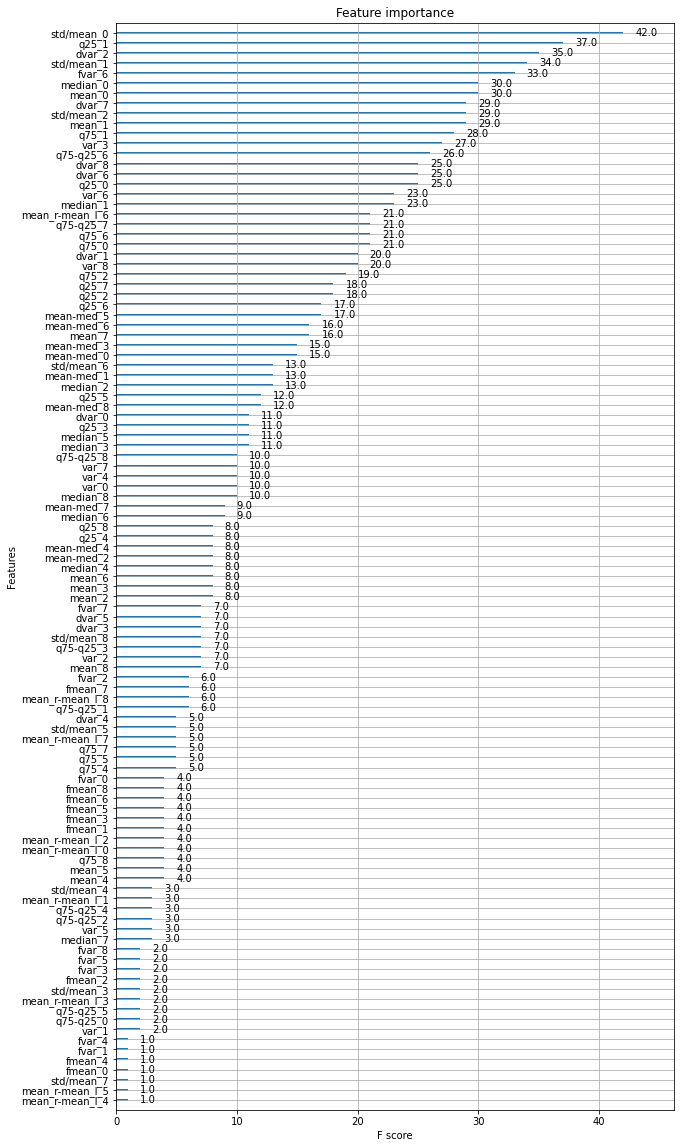

In [29]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(bst, ax=ax);

### Посмотрим, какие метрики получаются на тестовой выборке

In [30]:
test_predict = bst.predict(dtest)
test_predict.shape

(2947, 6)

In [31]:
test_predict_labels = test_predict.argmax(1)
test_predict_labels

array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

In [39]:
precision = precision_score(y_test_num, test_predict_labels, average='micro')
recall = recall_score(y_test_num, test_predict_labels, average='micro')
roc_auc = roc_auc_score(y_test, test_predict, multi_class="ovo")
print(f"precision = {round(precision, 3)}")
print(f"recall = {round(recall, 3)}")
print(f"roc_auc = {round(roc_auc, 3)}")

precision = 0.925
recall = 0.925
roc_auc = 0.993
